In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import numpy as np
import pandas as pd
import re

In [2]:
train_set = pd.read_csv('data/Price_euros_train.csv')
test_set = pd.read_csv('data/Price_euros_test.csv')
sub_set = pd.read_csv('data/Sample_submition.csv')

In [3]:
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1108 non-null   int64  
 1   Company           1108 non-null   object 
 2   Product           1108 non-null   object 
 3   TypeName          1108 non-null   object 
 4   Inches            1108 non-null   float64
 5   ScreenResolution  1097 non-null   object 
 6   Cpu               1108 non-null   object 
 7   Ram               1108 non-null   object 
 8   Memory            1108 non-null   object 
 9   Gpu               1108 non-null   object 
 10  OpSys             1055 non-null   object 
 11  Weight            1086 non-null   object 
 12  Price_euros       1108 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 112.7+ KB
None


In [4]:
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         195 non-null    int64  
 1   Company           195 non-null    object 
 2   Product           195 non-null    object 
 3   TypeName          195 non-null    object 
 4   Inches            195 non-null    float64
 5   ScreenResolution  193 non-null    object 
 6   Cpu               195 non-null    object 
 7   Ram               195 non-null    object 
 8   Memory            195 non-null    object 
 9   Gpu               195 non-null    object 
 10  OpSys             183 non-null    object 
 11  Weight            191 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 18.4+ KB
None


In [5]:
def top_columns_with_nulls(dataframe, top_n=5):
    total_rows = len(dataframe)
    null_counts = dataframe.isnull().sum()
    null_percentage = (null_counts / total_rows) * 100
    null_info_df = pd.DataFrame({
        'Column': null_counts.index,
        'Null Count': null_counts.values,
        'Null Percentage': null_percentage.values
    })
    sorted_nulls = null_info_df.sort_values(by='Null Count', ascending=False)
    return sorted_nulls.head(top_n)

print(top_columns_with_nulls(test_set))
print()
print(top_columns_with_nulls(train_set))

              Column  Null Count  Null Percentage
10             OpSys          12         6.153846
11            Weight           4         2.051282
5   ScreenResolution           2         1.025641
0          laptop_ID           0         0.000000
3           TypeName           0         0.000000

              Column  Null Count  Null Percentage
10             OpSys          53         4.783394
11            Weight          22         1.985560
5   ScreenResolution          11         0.992780
1            Company           0         0.000000
0          laptop_ID           0         0.000000


In [6]:
def delete_null_rows(dataframe):
    cleaned_df = dataframe.dropna()
    print(f"Rows removed: {len(dataframe) - len(cleaned_df)}")
    return cleaned_df
def auto_fill_nulls(dataframe):
    filled_df = dataframe.copy()
    for column in filled_df.columns:
        if filled_df[column].isnull().sum() > 0:  
            if np.issubdtype(filled_df[column].dtype, np.number):
                median_value = filled_df[column].median()
                filled_df[column].fillna(median_value, inplace=True)
                print(f"Filled nulls in numeric column '{column}' with median value: {median_value}")
            else:
                top_3_values = filled_df[column].value_counts().index[:3]
                if len(top_3_values) > 0:  
                    random_choice = np.random.choice(top_3_values)
                    filled_df[column].fillna(random_choice, inplace=True)
                    print(f"Filled nulls in non-numeric column '{column}' with random choice from top 3: {random_choice}")
                else:
                    print(f"Column '{column}' has no valid non-null values to use for filling.")
    return filled_df

In [7]:
def RAM_to_int(df):
    df = df.copy()
    df['Ram'] = (
        df['Ram']
        .str.replace('[A-Za-z]', '', regex=True)
        .str.strip()
        .astype(float)
    )
    return df

def kg_to_float(df, column_name):
    df = df.copy()
    df[column_name] = (
        df[column_name]
        .str.replace('kg', '', regex=False)
        .str.strip()
        .astype(float)
    )
    return df

def gpu_to_int(df):
    df = df.copy()
    conditions = [
        df['Gpu'].str.contains('intel', case=False, na=False),
        df['Gpu'].str.contains('amd', case=False, na=False),
        df['Gpu'].str.contains('nvidia', case=False, na=False)
    ]

    choices = [1, 2, 3]
    df['Gpu'] = np.select(conditions, choices, default=4).astype(int)
    return df

def cpu_to_freq(df):
    df = df.copy()
    df['Cpu'] = df['Cpu'].str.extract(r'(\d+(?:\.\d+)?)\s*GHz', expand=False)
    df['Cpu'] = pd.to_numeric(df['Cpu'], errors='coerce') 
    return df

def screen_resolution_categorize(df):
    df = df.copy()
    resolution_pattern = r'(\d+)x(\d+)'
    
    resolutions = df['ScreenResolution'].str.extract(resolution_pattern)
    
    resolutions = resolutions.apply(pd.to_numeric, errors='coerce')
    
    df['ScreenResolution_Product'] = resolutions[0] * resolutions[1]
    
    df['ScreenResolution'] = df['ScreenResolution_Product'].apply(
        lambda x: 1 if x < 2073600 else (2 if x == 2073600 else 3)
    )
    
    df.drop('ScreenResolution_Product', axis=1, inplace=True)
    
    return df

def memory_to_features(df):
    df = df.copy()
    
    def parse_memory(mem_str):
        parts = mem_str.split('+')
        
        total_hdd = 0
        total_ssd = 0
        total_flash = 0
        
        for part in parts:
            part = part.strip().lower()
            match = re.search(r'(\d+)(tb|gb)', part)
            if not match:
                continue
            size = int(match.group(1))
            unit = match.group(2)
            
            if unit == 'tb':
                size *= 1000
            
            if 'hdd' in part:
                total_hdd += size
            elif 'ssd' in part:
                total_ssd += size
            elif 'flash' in part:
                total_flash += size
        
        return total_hdd, total_ssd, total_flash
    
    parsed = df['Memory'].apply(parse_memory)
    df['Total_HDD_GB'] = parsed.apply(lambda x: x[0])
    df['Total_SSD_GB'] = parsed.apply(lambda x: x[1])
    df['Total_Flash_GB'] = parsed.apply(lambda x: x[2])
    
    df.drop('Memory', axis=1, inplace=True)
    return df

def frequency_encode(df, column_name):
    freq = df[column_name].value_counts()
    df[column_name] = df[column_name].map(freq)
    return df

def frequency_encode_companies_products(df):
    df = df.copy()
    df = frequency_encode(df, 'Company')
    df = frequency_encode(df, 'Product')
    df = frequency_encode(df, 'OpSys')
    return df

In [8]:
pipeline = Pipeline([
    ('ram_to_int', FunctionTransformer(RAM_to_int, validate=False)),
    ('weight_to_float', FunctionTransformer(lambda df: kg_to_float(df, 'Weight'), validate=False)),
    ('gpu_to_int', FunctionTransformer(gpu_to_int, validate=False)),
    ('cpu_to_freq', FunctionTransformer(cpu_to_freq, validate=False)),
    ('screen_resolution', FunctionTransformer(screen_resolution_categorize, validate=False)),
    ('memory_to_features', FunctionTransformer(memory_to_features, validate=False)),
    ('freq_encode', FunctionTransformer(frequency_encode_companies_products, validate=False)),
    ('scaler', StandardScaler())
])



In [9]:
train_set = pd.read_csv('data/Price_euros_train.csv')
test_set = pd.read_csv('data/Price_euros_test.csv')
sub_set = pd.read_csv('data/Sample_submition.csv')

test_set = auto_fill_nulls(test_set).drop(columns=['laptop_ID','TypeName'])
# dropped_test = delete_null_rows(test_set)
train_set =  auto_fill_nulls(train_set).drop(columns=['laptop_ID', 'TypeName'])
# dropped_train = delete_null_rows(train_set)

# train_set.drop(columns=['TypeName'], inplace=True)
# test_set.drop(columns=['TypeName'], inplace=True)

X_train = train_set.drop('Price_euros', axis=1)
y_train = train_set['Price_euros']

X_test = test_set.copy() 

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(test_set)

Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: 1366x768
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Windows 7
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.2kg
Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Linux
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.2kg


C:\Users\1TB\AppData\Local\Temp\ipykernel_22160\3784479130.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_df[column].fillna(random_choice, inplace=True)
C:\Users\1TB\AppData\Local\Temp\ipykernel_22160\3784479130.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [10]:
"""

filled_test = auto_fill_nulls(test_set)
dropped_test = delete_null_rows(test_set)
filled_train =  auto_fill_nulls(train_set)
dropped_train = delete_null_rows(train_set)
"""
X_test[0]


array([-2.18356596, -0.41433371,  0.39944154, -1.46452637,  1.38666763,
       -0.85969873,  0.27093337, -1.60913627,  0.0909802 ,  1.11718807,
       -0.97963003, -0.14666339])

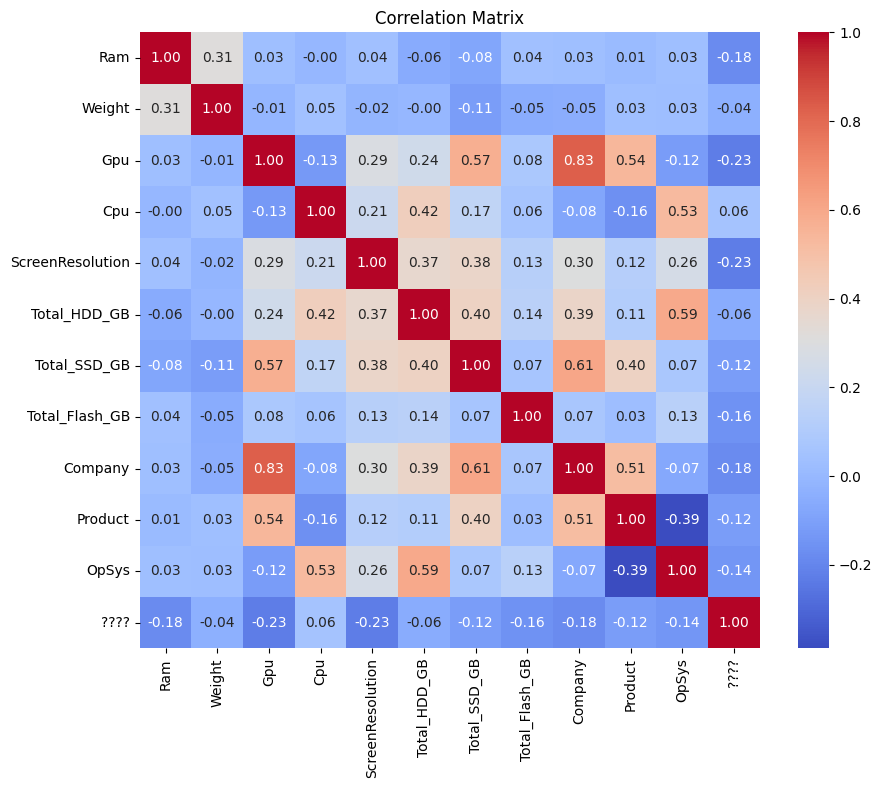

,Ram,Weight,Gpu,Cpu,ScreenResolution,Total_HDD_GB,Total_SSD_GB,Total_Flash_GB,Company,Product,OpSys,????
0,-2.122833,-0.732257,-1.221219,-1.464526,-0.976340,-0.071167,-0.845030,-2.056445,-1.068903,-0.811399,-0.979630,4.143846
1,-2.122833,0.539437,0.258515,2.021392,0.795916,1.505896,0.270933,-2.056445,-0.321084,-0.811399,1.781016,-0.146663
2,-2.122833,0.539437,-1.221219,2.021392,1.583585,-0.071167,-0.845030,-2.056445,-1.023118,-0.811399,0.400693,-0.146663
3,-1.223982,0.539437,0.399442,-1.464526,1.386668,-0.859699,0.270933,0.530690,0.090980,0.152894,-0.979630,-0.146663
4,-2.122833,0.539437,0.258515,2.021392,-0.188671,1.505896,-0.845030,-2.059467,-0.000590,-0.811399,-0.979630,8.434355
...,...,...,...,...,...,...,...,...,...,...,...,...
1103,-0.689530,-0.414334,0.399442,-1.464526,0.402081,-0.859699,1.386897,0.530690,0.243596,0.152894,-0.979630,-0.146663
1104,0.719480,-0.414334,-0.727974,0.278433,0.402081,-0.859699,-0.845030,0.530690,-0.366868,-0.811399,-0.289468,-0.146663
1105,0.719480,-0.096410,-0.727974,-1.464526,-1.370175,-1.253965,-0.845030,0.530690,-0.824717,-0.811399,-0.979630,1.998591
1106,0.488694,-0.573296,0.399442,-1.464526,0.402081,-0.465433,0.270933,0.530690,0.228335,1.117188,-0.979630,-0.146663


In [ ]:

final_feature_names = [
    'Ram', 
    'Weight', 
    'Gpu', 
    'Cpu', 
    'ScreenResolution', 
    'Total_HDD_GB', 
    'Total_SSD_GB', 
    'Total_Flash_GB', 
    'Company', 
    'Product', 'OpSys', '????'
]
data_df = pd.DataFrame(X_train, columns=final_feature_names)

numerical_cols = data_df.select_dtypes(include=['number'])
correlation_matrix = numerical_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
data_df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_tr, y_tr)

y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation MSE:", mse)
print("Validation R²:", r2)

test_predictions = model.predict(X_test)

Validation MSE: 169814.31393412364
Validation R²: 0.6535620330646887


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    random_state=42,
    n_jobs=-1,
    verbosity=0  
)
xgb_model.fit(X_tr, y_tr)
y_pred_xgb = xgb_model.predict(X_val)

mse_xgb = mean_squared_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("XGBoost Validation MSE:", mse_xgb)
print("XGBoost Validation R²:", r2_xgb)
test_predictions = xgb_model.predict(X_test)

XGBoost Validation MSE: 98759.05386796585
XGBoost Validation R²: 0.798521779196154


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 5, 7],           
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],     
    'colsample_bytree': [0.6, 0.8, 1.0]  
}

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_tr, y_tr)

print("Best Parameters from GridSearchCV:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_

y_pred_best_xgb = best_xgb.predict(X_val)

mse_best_xgb = mean_squared_error(y_val, y_pred_best_xgb)
r2_best_xgb = r2_score(y_val, y_pred_best_xgb)

print("Best XGBoost Validation MSE:", mse_best_xgb)
print("Best XGBoost Validation R²:", r2_best_xgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters from GridSearchCV: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Validation MSE: 76274.71903897724
Best XGBoost Validation R²: 0.8443920422239773


In [80]:
expected_length = 195
actual_length = len(test_predictions)

if actual_length != expected_length:
    raise ValueError(f"Expected {expected_length} predictions, but got {actual_length}.")

index_values = np.arange(expected_length)

submission_df = pd.DataFrame({
    'index': index_values,
    'Price_euros': test_predictions
})

print(submission_df.head())
print(submission_df.tail())

submission_df.to_csv('Submission.csv', index=False)

print("Submission file 'Submission.csv' has been created successfully.")

   index  Price_euros
0      0   499.060272
1      1  2901.206299
2      2   752.489380
3      3  2192.861084
4      4   567.704834
     index  Price_euros
190    190   669.230957
191    191   899.992432
192    192  1515.287231
193    193  1763.372559
194    194  1742.261108
Submission file 'Submission.csv' has been created successfully.
